### 一.简介

adaboost是一种boosting方法，它的要点包括如下两方面：   

#### 1.模型生成
每一个基分类器会基于上一轮分类器在训练集上的表现，对样本做权重调整，使得错分样本的权重增加，正确分类的样本权重降低，所以当前轮的训练更加关注于上一轮误分的样本；   

#### 2.模型组合
adaboost是采用的加权投票的方法   

简单来说，adaboost算法涉及两种权重的计算：**样本权重**、**分类器权重**，接下来直接讲算法流程

### 二.算法流程

输入：训练集$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$，其中$x_i\in R^n,y_i\in\{+1,-1\},i=1,2,...,N$   

输出：最终分类器$G(x)$  

>（1）初始化训练数据的权重分布：  

$$
D_1=(w_{11},...,w_{1i},...,w_{1N}),w_{1i}=\frac{1}{N},i=1,2,...,N
$$  

>（2）对$m=1,2,...,M:$   

>>（2.1）使用具有权重分布$D_m$的训练数据集学习，得到基本分类器：$G_m(x)$   
>>（2.2）计算$G_m(x)$在训练集上的分类误差率：$e_m=\sum_{i=1}^NP(G_m(x_i)\neq y_i)=\sum_{i=1}^Nw_{mi}I(G_m(x_i)\neq y_i)$  
>>（2.3）计算$G_m(x)$的权重系数：$\alpha_m=\frac{1}{2}ln\frac{1-e_m}{e_m}$  
>>（2.4）更新训练样本权重：  
$$
w_{m+1,i}=\frac{w_{mi}}{Z_m}exp(-\alpha_my_iG_m(x_i)),i=1,2,...,N
$$  
这里$Z_m$是归一化因子   

>（3）基于基分类器，构建最终的分类器：  

$$
G(x)=sign(\sum_{m=1}^M\alpha_mG_m(x))
$$

简单来说大致流程如下：  
![avatar](./source/10_adaboost训练.png)

### 三.代码实现

In [1]:
import os
os.chdir('../')
from ml_models import utils
from ml_models.tree import CARTClassifier
import copy
import numpy as np
%matplotlib inline


"""
AdaBoost分类器的实现，封装到ml_models.ensemble
"""

class AdaBoostClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0):
        """
        :param base_estimator: 基分类器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基分类器迭代数量
        :param learning_rate: 学习率，降低后续基分类器的权重，避免过拟合
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = CARTClassifier(max_depth=2)
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)

        # 记录estimator权重
        self.estimator_weights = []

    def fit(self, x, y):
        n_sample = x.shape[0]
        sample_weights = np.asarray([1.0] * n_sample)
        for index in range(0, self.n_estimators):
            self.base_estimator[index].fit(x, y, sample_weight=sample_weights)

            indicates = (self.base_estimator[index].predict(x) == y).astype(int)
            # 计算误分率
            error_rate = np.sum([sample_weights[j] * (1.0 - indicates[j]) for j in range(0, n_sample)]) / n_sample

            # 计算权重系数
            alpha_rate = 1.0 / 2.0 * np.log((1 - error_rate) / (error_rate + 1e-7))
            alpha_rate = min(10.0, alpha_rate)
            self.estimator_weights.append(alpha_rate)

            # 更新样本权重
            for j in range(0, n_sample):
                sample_weights[j] = sample_weights[j] * np.exp(-1.0 * alpha_rate * np.power(-1.0, 1 - indicates[j]))
            sample_weights = sample_weights / np.sum(sample_weights) * n_sample
        # 更新estimator权重
        for i in range(0, self.n_estimators):
            self.estimator_weights[i] *= np.power(self.learning_rate, i)

    def predict_proba(self, x):
        # TODO:并行优化
        result = np.sum(
            [self.base_estimator[j].predict_proba(x) * self.estimator_weights[j] for j in
             range(0, self.n_estimators)],
            axis=0)
        return result / result.sum(axis=1, keepdims=True)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [2]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

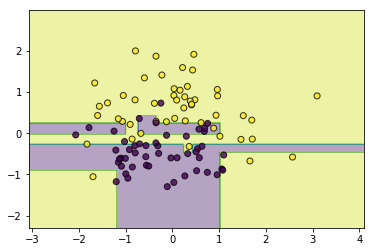

In [3]:
# 同质
classifier = AdaBoostClassifier(base_estimator=CARTClassifier(max_depth=2),n_estimators=10)
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

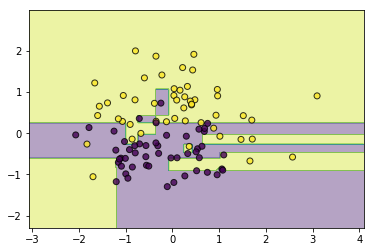

In [4]:
#异质
from ml_models.linear_model import LogisticRegression
from ml_models.svm import SVC
classifier = AdaBoostClassifier(base_estimator=[LogisticRegression(),SVC(kernel='rbf',C=5.0),CARTClassifier()])
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

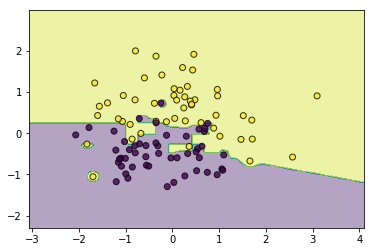

In [5]:
# 权重衰减
classifier = AdaBoostClassifier(base_estimator=[LogisticRegression(),SVC(kernel='rbf',C=5.0),CARTClassifier()],learning_rate=0.5)
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

### 四.问题讨论

#### 1.基本要求：弱可学习
注意有个基本要求，那就是$e_m<0.5$，即分类器至少是弱可学习的，这样才能保证$\alpha_m>0$，此时样本的权重调整（如下公式）才有意义，即正确分类的样本权重降低，错误分类的样本权重升高：  

$$
w_{m+1,i}=\left\{\begin{matrix}
\frac{w_{mi}}{Z_m}e^{-\alpha_m}, & G_m(x_i)= y_i \\ 
\frac{w_{mi}}{Z_m}e^{\alpha_m} & G_m(x_i)\neq y_i
\end{matrix}\right.
$$   

对于二分类问题，弱可学习其实是很容易保证的，对于$e_m>0.5$的情况，只需要对其预测取反，即可得到$1-e_m<0.5$的错误率

#### 2.基分类器不支持样本权重怎么办？
对于不能支持样本权重训练的基分类器，可以通过样本重采样来实现

### 五.训练误差分析
这一部分证明训练误差会随着基分类器的数量增加而指数下降，首先抛出第一个不等式关系：   

$$
关系式1：\frac{1}{N}\sum_{i=1}^NI(G(x_i)\neq y_i)\leq \frac{1}{N}\sum_{i=1}^Nexp(-y_if(x_i))=\prod_{m=1}^MZ_m
$$  

这里$f(x)=\sum_{m=1}^M\alpha_mG_m(x),G(x)=sign(f(x)),Z_m$与上面的定义一样，前半部分很好证明：如果$G(x_i)\neq y_i$，则$y_if(x_i)<0$，所以$exp(-y_if(x_i))\geq 1=I(G(x_i)\neq y_i)$，而对于$G(x_i)= y_i$的情况，显然有$exp(-y_if(x_i))\geq 0=I(G(x_i\neq y_i))$；   

接下来证明后半部分，根据之前的推导，有如下的两点条件需要注意：  

$$
条件1:w_{1i}=\frac{1}{N},i=1,2,...,N\\
条件2:w_{mi}exp(-\alpha_my_iG_m(x_i))=Z_mw_{m+1,i},i=1,2,...,N,m=1,2,...,M
$$  

所以：  

$$
\frac{1}{N}\sum_{i=1}^Nexp(-y_if(x_i))\\
=\frac{1}{N}\sum_{i=1}^Nexp(-\sum_{m=1}^M\alpha_my_iG_m(x_i)))\\
=\sum_{i=1}^N \frac{1}{N}\prod_{m=1}^Mexp(-\alpha_my_iG_m(x_i))\\
=\sum_{i=1}^N w_{1i}\prod_{m=1}^Mexp(-\alpha_my_iG_m(x_i))(用到了条件1)\\
=\sum_{i=1}^N w_{1i}exp(-\alpha_1y_iG_1(x_i))\prod_{m=2}^Mexp(-\alpha_my_iG_m(x_i))\\
=\sum_{i=1}^N Z_1w_{2i}\prod_{m=2}^Mexp(-\alpha_my_iG_m(x_i))(用到了条件2)\\
=Z_1\sum_{i=1}^N w_{2i}\prod_{m=2}^Mexp(-\alpha_my_iG_m(x_i))\\
=Z_1Z_2\sum_{i=1}^N w_{3i}\prod_{m=3}^Mexp(-\alpha_my_iG_m(x_i))\\
=\cdots\\
=\prod_{m=1}^MZ_m
$$  

接下来要抛出第二个关系式，对于二分类问题有如下不等式成立：  

$$
关系式2：\prod_{m=1}^MZ_m=\prod_{m=1}^M[2\sqrt{e_m(1-e_m)}]=\prod_{m=1}^M\sqrt{1-4\gamma_m^2}\leq exp(-2\sum_{i=1}^M\gamma_m^2)
$$  

这里：$\gamma_m=\frac{1}{2}-e_m$，首先证明等式部分，由前面的算法部分，我们知道$e_m=\sum_{i=1}^Nw_{mi}I(G_m(x_i)\neq y_i)$，所以：  

$$
Z_m=\sum_{i=1}^Nw_{mi}exp(-\alpha_my_iG_m(x_i))\\
=\sum_{y_i=G_m(x_i)}w_{mi}e^{-\alpha_m}+\sum_{y_i\neq G_m(x_i)}w_{mi}e^{\alpha_m}\\
=(1-e_m)e^{-\alpha_m}+e_me^{\alpha_m}\\
=2\sqrt{e_m(1-e_m)}\\
=\sqrt{1-4\gamma_m^2}
$$  

至于不等式部分，其实对于$\forall 0\leq x\leq 1$，都有$e^{-x/2}\geq \sqrt{1-x}$恒成立（证明从略，直观理解如下图），将$x$替换为$4\gamma_m^2$即可得到上面的不等式，从而关系式2得到证明；  

接下来简单做一个推论：一定能找到一个$\gamma>0$，对所有$\gamma_m\geq\gamma$成立，则有如下关系：  

$$
关系式3：exp(-2\sum_{i=1}^M\gamma_m^2)\leq exp(-2M\gamma^2)
$$  

结合关系式1、2、3可以得出：  

$$
\frac{1}{N}\sum_{i=1}^NI(G(x_i)\neq y_i)\leq exp(-2M\gamma^2)
$$  

即adaboost的误差上界会随着$M$的增加以指数速率下降

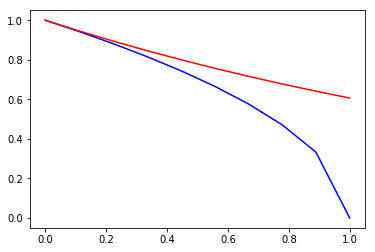

In [13]:
import matplotlib.pyplot as plt
x=np.linspace(0,1,10)
plt.plot(x,np.sqrt(1-x),'b')
plt.plot(x,np.exp(-0.5*x),'r')